### MNIST Performance Improvement

In [2]:
import torchvision
from torchvision import transforms as transforms
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.init
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Linear

In [4]:
train_set = torchvision.datasets.MNIST(root='./content',
                                        train=True,
                                        download=False,
                                        transform=transforms.ToTensor())

test_set = torchvision.datasets.MNIST(root='./content',
                                        train=False,
                                        download=False,
                                        transform=transforms.ToTensor())

In [5]:
trainload = DataLoader(train_set, batch_size=64, \
                       shuffle=True, num_workers=4)

testload = DataLoader(test_set, batch_size=64, \
                       shuffle=False, num_workers=4)

In [6]:
class mymodels(nn.Module):
    def __init__(self):
        super(mymodels, self).__init__()
        
        self.layer1 = nn.Linear(784,128, bias=True)
        nn.init.xavier_uniform_(self.layer1.weight)

        self.bach1 = nn.BatchNorm1d(128)
        self.Re1 = nn.ReLU()
        
        self.layer2 = nn.Linear(128,64, bias=True)
        nn.init.xavier_uniform_(self.layer2.weight)
        
        self.bach2 = nn.BatchNorm1d(64)
        self.Re2 = nn.ReLU()
        
        self.layer3 = nn.Linear(64,10, bias=True)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.bach1(out)
        out = self.Re1(out)
        
        out = self.layer2(out)
        out = self.bach2(out)
        out = self.Re2(out)
        
        res = self.layer3(out)
        
        return res

In [7]:
mymod = mymodels()

In [10]:
optima = optim.Adam(mymod.parameters(), lr=0.001)

In [11]:
lossF = nn.CrossEntropyLoss().to(device)

In [12]:
total_number = len(trainload)
epoch = 3

for q in range(epoch):
    cal_cost = 0.0
    for i in trainload:
        image, labels = i
        
        ss = image.size(0)
        image = image.view(ss,-1)
        
        image = image.to(device)
        
        optima.zero_grad()
        
        pred = mymod(image)
        
        loos = lossF(pred, labels)
        
        loos.backward()
        
        optima.step()
        
        cal_cost += loos
        
    print(epoch, cal_cost)
print('finish')

3 tensor(269.7587, grad_fn=<AddBackward0>)
3 tensor(92.3253, grad_fn=<AddBackward0>)
3 tensor(64.0141, grad_fn=<AddBackward0>)
finish


In [14]:
with torch.no_grad():
    x_test = test_set.test_data.view(len(test_set),1,28,28).float().to(device)
    x_test = x_test.view(x_test.size(0),-1)
    y_test = test_set.test_labels.to(device)
    
    predic = mymod(x_test)
    cor_pre = torch.argmax(predic,1) == y_test
    acc = cor_pre.float().mean()
    print(acc.item())

0.9746000170707703


---

### CNN 2D

In [15]:
train_set = torchvision.datasets.MNIST(root = './content',
                                      download = False,
                                      train = True,
                                      transform=transforms.ToTensor())

test_set = torchvision.datasets.MNIST(root = './content',
                                     download = False,
                                     train = False,
                                     transform=transforms.ToTensor())

In [16]:
train_load = DataLoader(train_set, batch_size=128, shuffle=True,
                       num_workers=3)

In [18]:
class Imodel(nn.Module):
    def __init__(self):
        super(Imodel,self).__init__()
        
        self.conv_1 = nn.Conv2d(1,128,3,padding=5)
        nn.init.xavier_uniform_(self.conv_1.weight)
        self.batch_1 = nn.BatchNorm2d(128)
        self.relu_1 = nn.ReLU()
        self.Max_1 = nn.MaxPool2d(2)
        
        self.conv_2 = nn.Conv2d(128,64,3,padding=5)
        nn.init.xavier_uniform_(self.conv_2.weight)
        self.batch_2 = nn.BatchNorm2d(64)
        self.relu_2 = nn.ReLU()
        self.Max_2 = nn.MaxPool2d(2)
        
        #conv1:36(28-3+5*2/1 +1), max_1:18(36/2), 
        #conv2:26(18-3+5*2/1 +1), max_2:13(26/2)
        self.fc_1 = nn.Linear(13*13*64,128,bias=True)
        nn.init.xavier_uniform_(self.fc_1.weight)
        self.batch_3 = nn.BatchNorm1d(128)
        self.relu_3 = nn.ReLU()
        
        self.fc_2 = nn.Linear(128,10,bias=True)
        nn.init.xavier_uniform_(self.fc_2.weight)
        
    def forward(self,x):
        
        out = self.conv_1(x)
        out = self.batch_1(out)
        out = self.relu_1(out)
        out = self.Max_1(out)
        
        out = self.conv_2(out)
        out = self.batch_2(out)
        out = self.relu_2(out)
        out = self.Max_2(out)
        
        out = out.view(out.shape[0],-1)
        
        out = self.fc_1(out)
        out = self.batch_3(out)
        out = self.relu_3(out)
        
        out = self.fc_2(out)
        
        return out

In [19]:
Imod = Imodel()

In [20]:
optimizers = optim.Adam(Imod.parameters(),lr=0.001)

In [21]:
loss_Function = nn.CrossEntropyLoss().to(device)

In [ ]:
total = len(train_load)
epochs = 3

for k in range(epochs):
    cal_loss = 0.0
    for i in train_load:
        image, labels = i
        
        image = image.to(device)
        labels = labels.to(device)
        
        optimizers.zero_grad()
        
        hypothesis = Imod(image)
        
        loss_s = loss_Function(hypothesis, labels)
        
        loss_s.backward()
        
        optimizers.step()
        
        loss_val += loss_s
        
    print(epochs, loss_val)
print('finish')

In [22]:
pre_train_model = Imodel().to(device)
pre_train_model.load_state_dict(torch.load('./model_save/Imod.pth'))

<All keys matched successfully>

In [23]:
with torch.no_grad():
    x_test = test_set.test_data.view(len(test_set),1,28,28).float().to(device)
    y_test = test_set.test_labels.to(device)
    
    predict_val = pre_train_model(x_test)
    cor = torch.argmax(predict_val,1) == y_test
    correct = cor.float().mean()
    
    print(correct.item())

0.9908000230789185


---

### Image Compare

In [24]:
x_test_check = test_set.test_data.view(len(test_set),1,28,28).float()

In [26]:
x_test_check[0].shape

torch.Size([1, 28, 28])

In [28]:
x_test_check[0].squeeze().shape

torch.Size([28, 28])

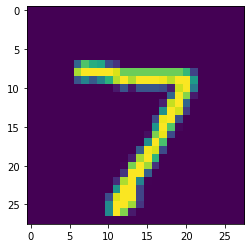

In [29]:
plt.imshow(x_test_check[0].squeeze())

In [33]:
predict_val.shape

torch.Size([10000, 10])

In [35]:
torch.argmax(predict_val[0])

tensor(7)